### Псевдообращение для блочных матриц

Пусть мы имеем дело с задачей обработки данных, которая зачастую сводится к решению системы линейных алгебраических уравнений. В большинстве случаев принимается, что входные данные известны в полном объёме, однако нередко возникают ситуации, когда данные поступают с некоторой задержкой или их обработка происходит последовательно. В такой ситуации к исходной матрице системы поэтапно добавляются столбцы, и для нахождения псевдорешения требуется пересчёт полученной матрицы на каждом этапе. В данном случае нахождение псевдообратной матрицы будет занимать порядка $O(n+k)^3$ операций, где $n$ - число столбцов исходной матрицы, $k$ число столбцов добавленной матрицы. Предложим алгоритм последовательной обработки данных, основанный на формуле блочного псевдообращения матриц полного столбцового ранга. При поступлении очередного блока данных нам уже известна псевдообратная матрица к блоку на предыдущем этапе, поэтому воспользуемся формулой блочного псевдообращения: $\begin{bmatrix} H_1&H_2 \end{bmatrix}^+ = \begin{bmatrix} E&H_1^+H_2 \\ H_2^+H_1 & E\end{bmatrix}^{-1}\begin{bmatrix} H_1^+ \\ H_2^+ \end{bmatrix}^+ $. Несмотря на то, что в формуле также используется псевдообращение матриц, оно затрагивает только блоки исходной матрицы, что позволяет сократить количество вычислений. Тогда сложность вычисления таким способом будет порядка $O(n^3+k^3)$.  
Покажем, что она алгоритм действительно работает.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time

In [5]:
# Задаём размеры (n, m) исходной матрицы и добавленной (n, k)
n = 500
m = 350
k = 10

# Задаём матрицы и считаем для них псевдообратную
H1 = np.random.randn(n, m)
H1_pinv = np.linalg.pinv(H1)
H2 = np.random.randn(n, k)
H2_pinv = np.linalg.pinv(H2)

# without alg
matrix = np.hstack((H1, H2))
matrix_pinv = np.linalg.pinv(matrix)

#with alg
bl1 = np.block([[np.eye(len(H1_pinv @ H2)), H1_pinv @ H2],[H2_pinv @ H1, np.eye(len(H2_pinv @ H1))]])
bl2 = np.vstack((H1_pinv, H2_pinv))
matrix_pinv_with_alg = np.linalg.inv(bl1) @ bl2

print(np.allclose(matrix_pinv, matrix_pinv_with_alg))
print(np.linalg.norm(matrix_pinv - matrix_pinv_with_alg))



True
9.139742129387233e-15


Убедились в этом, теперь сравним время вычисления с помощью алгоритма и наивным вычислением при различных числе столбцов добавленной матрицы.

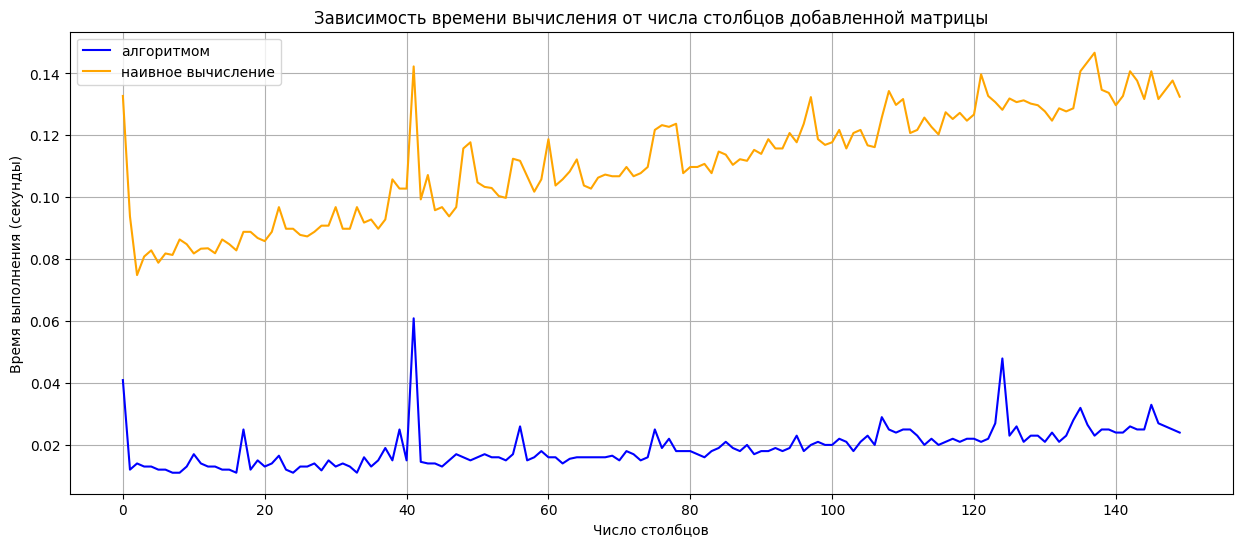

In [7]:
n = 500
m = 350
column_counts = np.arange(n - m)
execution_times_def = []
execution_times_method = []

H1 = np.random.randn(n, m)
H1_pinv = np.linalg.pinv(H1)

for k in range(1, n - m + 1):
  H2 = np.random.randn(n, k)
  H2_pinv = np.linalg.pinv(H2)
  matrix = np.hstack((H1, H2))

  #without method
  start = time.time()
  matrix_pinv = np.linalg.pinv(matrix)
  end = time.time()
  execution_times_def.append(end - start)

  #with method
  start = time.time()
  bl1 = np.block([[np.eye(len(H1_pinv @ H2)), H1_pinv @ H2],[H2_pinv @ H1, np.eye(len(H2_pinv @ H1))]])
  bl2 = np.vstack((H1_pinv, H2_pinv))
  matrix_pinv_with_alg = np.linalg.inv(bl1) @ bl2
  end = time.time()
  execution_times_method.append(end - start)

plt.figure(figsize=(15, 6))
plt.plot(column_counts, execution_times_method, label='алгоритмом', color='blue', linestyle='-')
plt.plot(column_counts, execution_times_def, label='наивное вычисление', color='orange', linestyle='-')
plt.xlabel('Число столбцов')
plt.ylabel('Время выполнения (секунды)')
plt.title('Зависимость времени вычисления от числа столбцов добавленной матрицы')
plt.grid(True)
plt.legend()
plt.show()

По графику видно, что вычисление псевдообратной матрицы с помощью алгоритма на порядок эффективнее наивного вычисления и он отлично себя показывает для любого числа столбцов $k < n - m$ добавленной матрицы.   
Посмотрим теперь насколько точен данный алгоритм для матриц с различным числом обусловленности.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


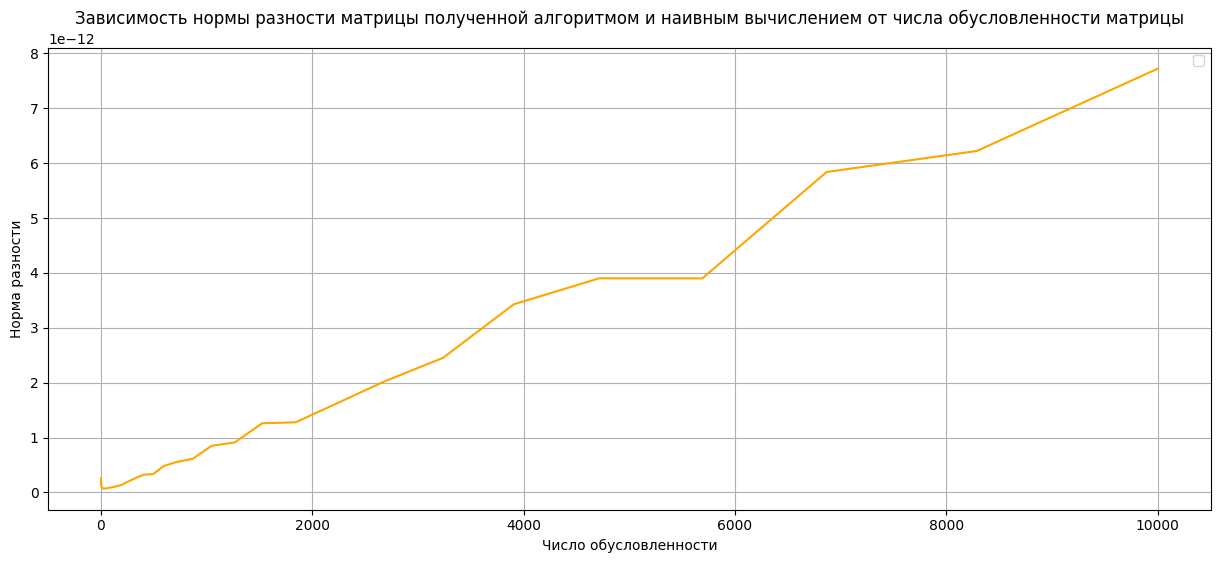

In [9]:
n = 500
m = 350
k = 50
cond = np.logspace(start=0, stop=4, num=50)
norm = np.array([])

for i in range(50):
  norm_j = np.array([])
  for j in range(10):
    H1 = np.random.randn(n, m)
    U, S, V = np.linalg.svd(H1, full_matrices=False)
    S_modified = np.linspace(1, cond[i], m)
    H1 = np.dot(U, np.dot(np.diag(S_modified), V))
    H1_pinv = np.linalg.pinv(H1)

    H2 = np.random.randn(n, k)
    H2_pinv = np.linalg.pinv(H2)
    matrix = np.hstack((H1, H2))

    #without method
    matrix_pinv = np.linalg.pinv(matrix)

    #with method
    bl1 = np.block([[np.eye(len(H1_pinv @ H2)), H1_pinv @ H2],[H2_pinv @ H1, np.eye(len(H2_pinv @ H1))]])
    bl2 = np.vstack((H1_pinv, H2_pinv))
    matrix_pinv_with_alg = np.linalg.inv(bl1) @ bl2
    
    norm_j = np.append(norm_j, [np.linalg.norm(matrix_pinv - matrix_pinv_with_alg)])
  norm = np.append(norm, np.mean(norm_j))

plt.figure(figsize=(15, 6))
plt.plot(cond, norm, color='orange', linestyle='-')
plt.xlabel('Число обусловленности')
plt.ylabel('Норма разности')
plt.title('Зависимость нормы разности матрицы полученной алгоритмом и наивным вычислением от числа обусловленности матрицы')
plt.grid(True)
plt.legend()
plt.show()

Видим, что даже для плохо обусловленных матриц алгоритм достаточно точно вычисляет псевдообратную матрицу.  
Теперь зададимся вопросом, а будет ли эффективно вычислять псевдообратную матрицу данным методом без учёта того, что мы знаем псевдообратную для исходной матрицы.

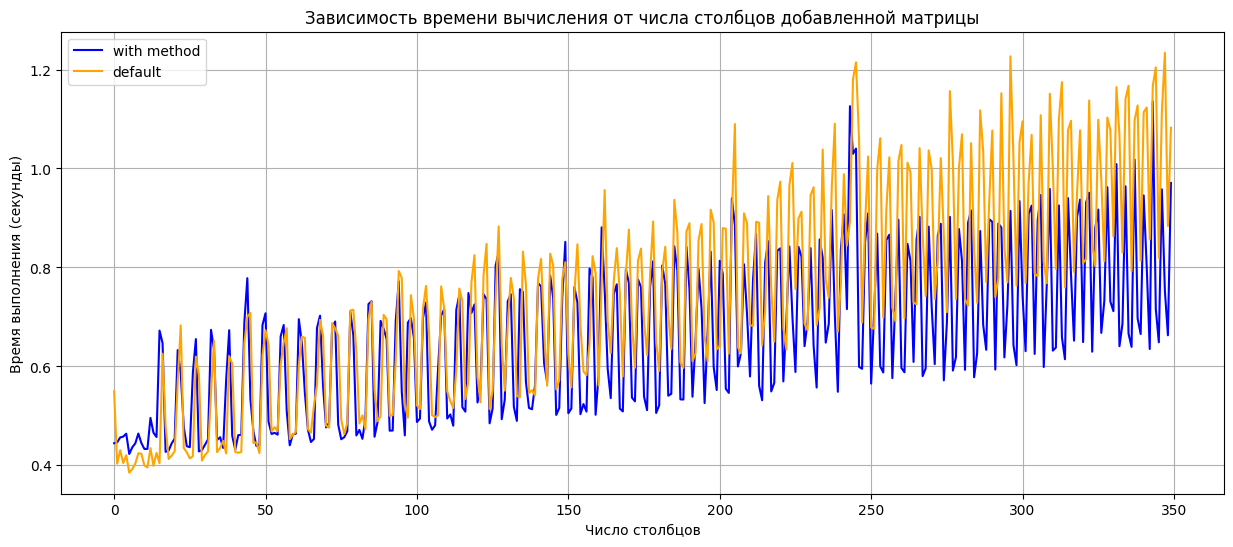

In [17]:
n = 1000
m = 650
column_counts = np.arange(n - m)
execution_times_def = []
execution_times_method = []

for k in range(1, n - m + 1):
  H1 = np.random.randn(n, m)
  H2 = np.random.randn(n, k)
  matrix = np.hstack((H1, H2))

  #without method
  start = time.time()
  matrix_pinv = np.linalg.pinv(matrix)
  end = time.time()
  execution_times_def.append(end - start)

  #with method
  start = time.time()
  H1_pinv = np.linalg.pinv(H1)
  H2_pinv = np.linalg.pinv(H2)
  bl1 = np.block([[np.eye(len(H1_pinv @ H2)), H1_pinv @ H2],[H2_pinv @ H1, np.eye(len(H2_pinv @ H1))]])
  bl2 = np.vstack((H1_pinv, H2_pinv))
  matrix_pinv_with_alg = np.linalg.inv(bl1) @ bl2
  end = time.time()
  execution_times_method.append(end - start)

plt.figure(figsize=(15, 6))
plt.plot(column_counts, execution_times_method, label='with method', color='blue', linestyle='-')
plt.plot(column_counts, execution_times_def, label='default', color='orange', linestyle='-')
plt.xlabel('Число столбцов')
plt.ylabel('Время выполнения (секунды)')
plt.title('Зависимость времени вычисления от числа столбцов добавленной матрицы')
plt.grid(True)
plt.legend()
plt.show()

По графику можно сделать вывод, что для небольшого числа столбцов добавленной матрицы наивный метод вычисления работает эффективнее, но с увеличением числа добавленных столбцов эффективнее становится вычисление нашим алгоритмом. Разница во времени хоть и небольшая, но для задач с большими размерами матриц это может ускорить процесс вычисления.